# Phase Floated Posterior

-   Draw the phase-floated (2-dimensional) analysis results.


## Setup

### Import

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation

from FigureSetting import set_nature_style, mm_to_inches, colors, color_blur

### Figure Setting

In [2]:
set_nature_style()

figsize = (180 * mm_to_inches, 120 * mm_to_inches)
plt.rcParams['figure.figsize'] = figsize

figure_dir = "../figure/"
figure_name = "PhaseFloatedPosterior.pdf"
figure_path = figure_dir + figure_name


## Read Data

In [3]:
dama_amplitude = {  # [dru]
    "2-6": (0.01014, 0.00074),
    "1-6": (0.01058, 0.00090),
    "1-3": (0.0191, 0.0020),
}
dama_phase = {  # [days]
    "2-6": (142.4, 4.2),
    "1-6": (144.5, 5.1),
    "1-3": (149.6, 5.9),
}


In [4]:
configurations = [  # [policy, energy_range]
    ("erc", "1-3"),
    ("nrc", "2-6"),
    ("erc", "1-6"),
    ("erc", "2-6"),
]

configuration_titles = {
    ("nrc", "2-6"): r"6.7-20$\mathrm{\,keV_{nr}}$",
    ("erc", "1-3"): r"1-3$\mathrm{\,keV_{ee}}$",
    ("erc", "1-6"): r"1-6$\mathrm{\,keV_{ee}}$",
    ("erc", "2-6"): r"2-6$\mathrm{\,keV_{ee}}$",
}


In [5]:
public_data_dir = "../data/"
histogram_path_format = public_data_dir + "TwoDimensionalPosterior_{policy}{energy_range}_histogram.csv"
pdf_path_format = public_data_dir + "TwoDimensionalPosterior_{policy}{energy_range}_pdf.csv"


In [6]:
histogram_dfs = {
    configuration: pd.read_csv(
        histogram_path_format.format(
            policy=configuration[0], energy_range=configuration[1]
        )
    )
    for configuration in configurations
}
pdf_dfs = {
    configuration: pd.read_csv(
        pdf_path_format.format(
            policy=configuration[0], energy_range=configuration[1]
        )
    )
    for configuration in configurations
}


In [7]:
histogram_dfs[("nrc", "2-6")].head()


,amplitude,phase,mcmc_samples
0,0.00001,0.253646,7178
1,0.00001,0.760938,8142
2,0.00001,1.268229,6208
3,0.00001,1.775521,7648
4,0.00001,2.282812,6043


In [8]:
pdf_dfs[("nrc", "2-6")].head()


,amplitude,phase,pdf
0,0.00001,0.253646,0.683557
1,0.00001,0.760938,0.683554
2,0.00001,1.268229,0.683555
3,0.00001,1.775521,0.683560
4,0.00001,2.282812,0.683569


## Draw Plot

In [9]:
max_prob = 0.0
for configuration in configurations:
    histogram_df = histogram_dfs[configuration]

    # read bins
    amplitudes = histogram_df["amplitude"].values
    amplitude_centers = np.unique(amplitudes)
    num_amplitudes = len(amplitude_centers)
    amplitude_width = amplitude_centers[1] - amplitude_centers[0]
    amplitude_bins = np.append(
        amplitude_centers - amplitude_width / 2,
        amplitude_centers[-1] + amplitude_width / 2,
    )

    phases = histogram_df["phase"].values
    phase_centers = np.unique(phases)
    num_phases = len(phase_centers)
    phase_width = phase_centers[1] - phase_centers[0]
    phase_bins = np.append(
        phase_centers - phase_width / 2,
        phase_centers[-1] + phase_width / 2,
    )

    # rebin
    rebin = 2
    phase_bins_rebin = phase_bins[::rebin]
    amplitude_bins_rebin = amplitude_bins[::rebin]

    # maximum prob
    p = histogram_df["mcmc_samples"].values.reshape(
        (num_amplitudes // rebin, rebin, num_phases // rebin, rebin)
    ).mean(axis=(1, 3)).max() / histogram_df[
        "mcmc_samples"
    ].sum() / amplitude_width / phase_width

    print(configuration, p)

    if p > max_prob:
        max_prob = p

print("max_prob", max_prob)

('erc', '1-3') 0.45745186360777124
('nrc', '2-6') 1.0575938249224668
('erc', '1-6') 0.8996661284422246
('erc', '2-6') 1.5309863683712353
max_prob 1.5309863683712353


In [10]:
contour_color = colors["IbsRed"]
contour_linestyles = ["dotted", "dashdot", "dashed"]


Drawing... ('erc', '1-3')
Drawing... ('nrc', '2-6')
Drawing... ('erc', '1-6')
Drawing... ('erc', '2-6')


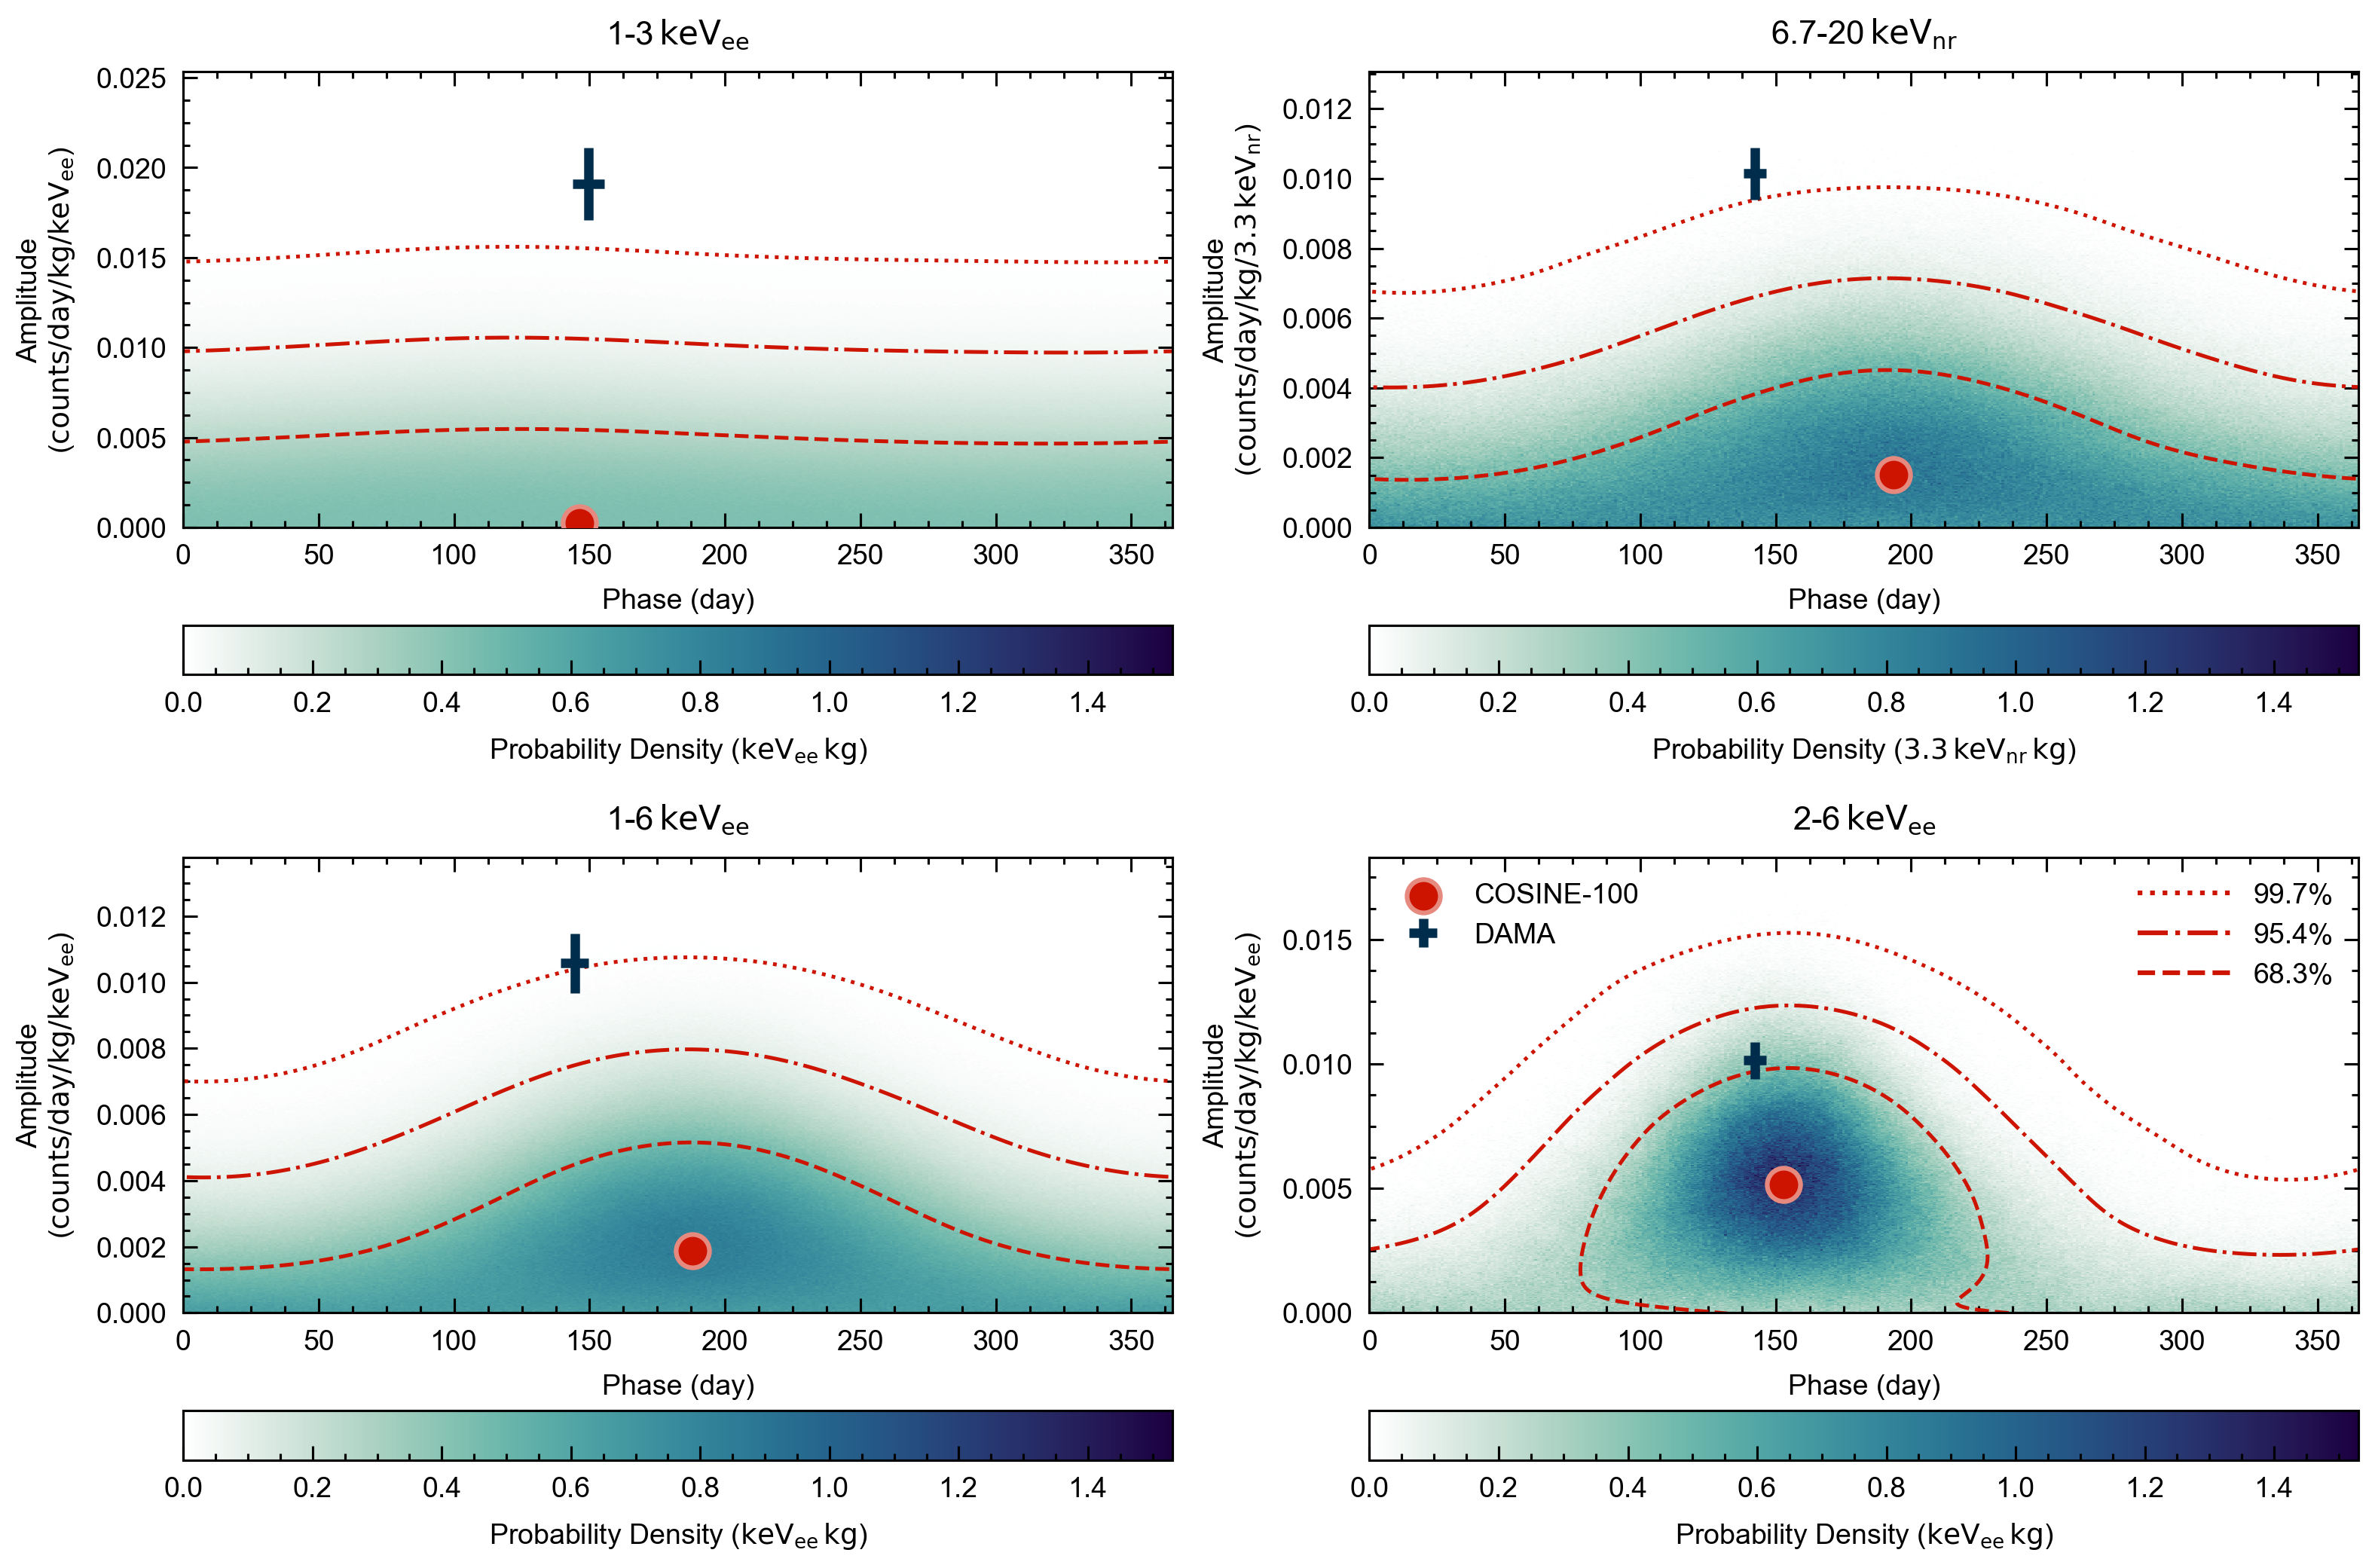

In [11]:
fig, axs = plt.subplots(2, len(configurations) // 2)

for ax, configuration in zip(axs.flatten(), configurations):
    histogram_df = histogram_dfs[configuration]
    pdf_df = pdf_dfs[configuration]

    policy, energy_range = configuration
    print("Drawing...", configuration)

    # read bins
    amplitudes = histogram_dfs[configuration]["amplitude"].values
    amplitude_centers = np.unique(amplitudes)
    num_amplitudes = len(amplitude_centers)
    amplitude_width = amplitude_centers[1] - amplitude_centers[0]
    amplitude_bins = np.append(
        amplitude_centers - amplitude_width / 2,
        amplitude_centers[-1] + amplitude_width / 2,
    )

    phases = histogram_dfs[configuration]["phase"].values
    phase_centers = np.unique(phases)
    num_phases = len(phase_centers)
    phase_width = phase_centers[1] - phase_centers[0]
    phase_bins = np.append(
        phase_centers - phase_width / 2,
        phase_centers[-1] + phase_width / 2,
    )

    # rebin
    rebin = 2
    phase_bins_rebin = phase_bins[::rebin]
    amplitude_bins_rebin = amplitude_bins[::rebin]

    # read posterior histogram
    counts = histogram_df["mcmc_samples"].values.reshape(
        (num_amplitudes, num_phases)
    )
    count_to_density = (
        1
        / np.sum(counts)
        / (amplitude_centers[1] - amplitude_centers[0])
        / (phase_centers[1] - phase_centers[0])
    )
    density = counts * count_to_density

    # rebin
    density_rebin = density.reshape(
        (num_amplitudes // rebin, rebin, num_phases // rebin, rebin)
    ).mean(axis=(1, 3))
    density_rebin_masked = np.ma.masked_where(density_rebin == 0, density_rebin)

    # read pdf and mirror
    pdf = pdf_df["pdf"].values.reshape((num_amplitudes, num_phases))

    phase_mirror_bins = np.concatenate(
        [
            phase_bins[num_phases // 2 : -1] - phase_bins[-1],
            phase_bins,
            phase_bins[1 : num_phases // 2 + 1] + phase_bins[-1],
        ]
    )
    amplitude_mirror_bins = np.concatenate(
        [
            -amplitude_bins[::-1],
            amplitude_bins[1:],
        ]
    )

    phase_mirror_centers = (phase_mirror_bins[1:] + phase_mirror_bins[:-1]) / 2
    amplitude_mirror_centers = (
        amplitude_mirror_bins[1:] + amplitude_mirror_bins[:-1]
    ) / 2

    phase_mirror_meshgrid, amplitude_mirror_meshgrid = np.meshgrid(
        phase_mirror_centers, amplitude_mirror_centers
    )

    pdf_mirror = np.concatenate(
        [
            pdf[:, num_phases // 2 :],
            pdf,
            pdf[:, : num_phases // 2],
        ],
        axis=1,
    )
    pdf_mirror = np.concatenate([pdf_mirror[::-1, ::-1], pdf_mirror[:]], axis=0)

    # evaluate contour
    hdr_probs = [2 * (norm.cdf(i) - 0.5) for i in range(3, 0, -1)]

    pdf_sorted = np.sort(pdf.flatten())
    pdf_sorted = np.flip(pdf_sorted)
    pdf_cumsum = np.cumsum(pdf_sorted)
    pdf_cumsum /= pdf_cumsum[-1]

    pdf_levels = [np.interp(p, pdf_cumsum, pdf_sorted) for p in hdr_probs]

    # pdf-maximum point
    pdf_max_index = np.argmax(pdf)
    pdf_max_amplitude_index, pdf_max_phase_index = np.unravel_index(
        pdf_max_index, pdf.shape
    )
    pdf_max_amplitude = amplitude_centers[pdf_max_amplitude_index]
    pdf_max_phase = phase_centers[pdf_max_phase_index]

    # draw
    pcm = ax.pcolormesh(
        phase_bins_rebin,
        amplitude_bins_rebin,
        density_rebin_masked,
        vmin=0,
        vmax=max_prob,
        zorder=1,
    )

    ax.contour(
        phase_mirror_meshgrid,
        amplitude_mirror_meshgrid,
        pdf_mirror,
        levels=pdf_levels,
        colors=contour_color,
        linestyles=contour_linestyles,
        linewidths=0.8,
        zorder=2,
    )

    contour_handles = list()
    for ls, p in zip(contour_linestyles, hdr_probs):
        l = f"{p:.1%}"
        _contour = ax.plot(
            [], [], color=contour_color, linewidth=1.0, label=l, linestyle=ls
        )
        contour_handles.append(_contour[0])

    # overlay DAMA and COSINE-100 best fits
    draw_dama = ax.errorbar(
        dama_phase[energy_range][0],
        dama_amplitude[energy_range][0],
        xerr=dama_phase[energy_range][1],
        yerr=dama_amplitude[energy_range][1],
        fmt=".",
        markersize=0.0,
        linewidth=2.0,
        color=colors["InfnDeepBlue"],
        label="DAMA",
        zorder=10,
    )

    draw_cosine = ax.scatter(
        pdf_max_phase,
        pdf_max_amplitude,
        marker=".",
        s=200,
        color=colors["IbsRed"],
        edgecolor=color_blur(colors["IbsRed"], 0.5),
        linewidth=1.0,
        label="COSINE-100",
        zorder=10,
    )

    # style
    contour_max = amplitude_mirror_meshgrid[pdf_mirror > pdf_levels[0]].max()
    ymax = 1.2 * max(
        contour_max,
        dama_amplitude[energy_range][0] + dama_amplitude[energy_range][1],
    )
    ax.set_ylim(0, ymax)
    ytick_width = (
        0.002
        if (configuration == ("nrc", "2-6") or configuration == ("erc", "1-6"))
        else 0.005
    )
    yticks = np.arange(0, ymax, ytick_width)
    y_minor_ticks = np.arange(0, ymax, ytick_width / 4)
    ax.set_yticks(yticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.xaxis.set_tick_params(which="both", direction="in", top=True)

    ax.set_xlim(0, phase_bins[-1])
    phase_ticks = np.arange(0, phase_bins[-1] + 1, 50, dtype="int")
    phase_minor_ticks = np.arange(0, phase_bins[-1] + 1, 50.0 / 4)
    ax.set_xticks(phase_ticks)
    ax.set_xticks(phase_minor_ticks, minor=True)
    ax.yaxis.set_tick_params(which="both", direction="in", right=True)
    ax.set_xlabel("Phase (day)")

    if policy == "nrc":
        unit = r"($\mathrm{counts/day/kg/3.3 \, keV_{nr}}$)"
    else:
        unit = r"($\mathrm{counts/day/kg/keV_{ee}}$)"
    ax.set_ylabel("Amplitude\n" + unit)

    # colorbar
    if policy == "nrc":
        unit = r" ($\mathrm{3.3\,keV_{nr} \, kg}$)"
    else:
        unit = r" ($\mathrm{keV_{ee} \, kg}$)"
    cbar = fig.colorbar(
        pcm,
        ax=ax,
        location="bottom",
        label="Probability Density" + unit,
    )
    cbar.set_ticks(np.arange(0, max_prob, 0.2))
    cbar.set_ticks(np.arange(0, max_prob, 0.05), minor=True)

    ax.set_title(configuration_titles[configuration])

# legend
contour_legend = axs.flatten()[-1].legend(
    handles=contour_handles,
    loc="upper right",
    frameon=False,
    handlelength=3.3,
)
best_fit_handles = [draw_cosine, draw_dama]
axs.flatten()[-1].legend(handles=best_fit_handles, loc="upper left", frameon=False)
axs.flatten()[-1].add_artist(contour_legend)

plt.tight_layout()
plt.savefig(figure_path)
plt.show()

## END-OF-NOTE